In [2]:
import sys 
sys.path.append("../")

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sn


from core.utils import find_non_numerical_columns,categorize_columns

%load_ext autoreload
%autoreload 2


/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-pac

## Load dataset

In [3]:
df = pd.read_excel("../data/assignement.xlsx")

## DataFrame analysis

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Country,Gender,Age,Tenure,CustomerFeedback,Balance (EUR),NumberOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Exited
0,747,15787619,Hsieh,844,France,Male,18,2,I can not link my card to any third-party plat...,160980.03,1,0,0,145936.28,0
1,1620,15770309,McDonald,656,France,Male,18,10,"Last week, I reached out to my bank's support ...",151762.74,1,0,1,127014.32,0
2,1679,15569178,Kharlamov,570,France,Female,18,4,NaN,82767.42,1,1,0,71811.90,0
3,2022,15795519,Vasiliev,716,Germany,Female,18,3,NaN,128743.80,1,0,0,197322.13,0
4,2137,15621893,Bellucci,727,France,Male,18,4,"Yo, I gotta give some love to this bank's cust...",133550.67,1,1,1,46941.41,0


### Basic description

In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance (EUR),NumberOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df.count(axis=0)

RowNumber           10000
CustomerId          10000
Surname             10000
CreditScore         10000
Country             10000
Gender              10000
Age                 10000
Tenure              10000
CustomerFeedback     3018
Balance (EUR)       10000
NumberOfProducts    10000
HasCreditCard       10000
IsActiveMember      10000
EstimatedSalary     10000
Exited              10000
dtype: int64

No duplicates but some CustomerFeedback are missing

In [7]:
print(f"Number of null elemnt in dataset : {df.isnull().values.sum()}")
for column in df.keys():
    if df[column].isnull().values.any() :
        print(f"{df[column].isnull().values.sum()} element null in column {column}")

Number of null elemnt in dataset : 6982
6982 element null in column CustomerFeedback


### Analysis distribution

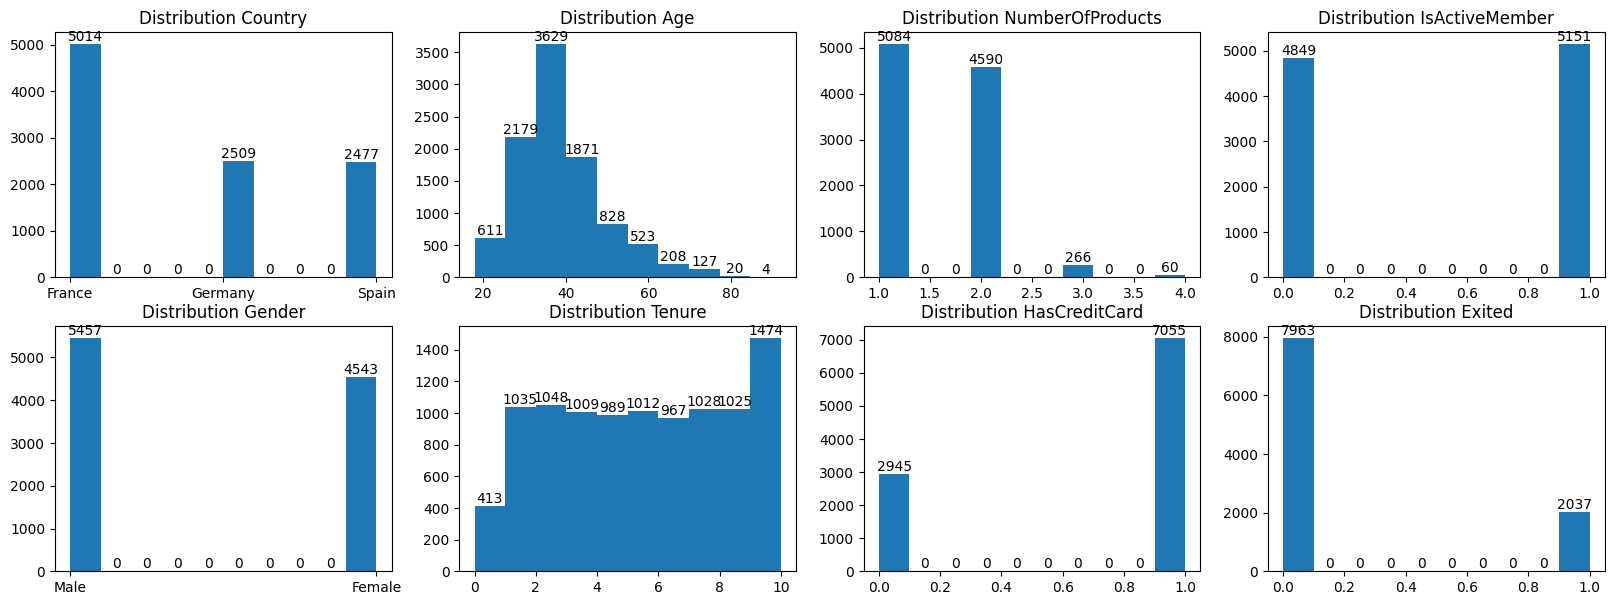

In [8]:
nb_columns_splitter  = 2
columns = ["Country","Gender", "Age", "Tenure", "NumberOfProducts",	"HasCreditCard","IsActiveMember","Exited",'Balance (EUR)'] 
fig , ax = plt.subplots(nb_columns_splitter,int(len(columns)/nb_columns_splitter) +1 , figsize=(20,7))
for pos,column in enumerate(columns) :
    labels = df[column].values
    counts, edges, bars  = ax[pos%nb_columns_splitter,pos//nb_columns_splitter].hist(labels,bins=10)
    ax[pos%nb_columns_splitter,pos//nb_columns_splitter].bar_label(bars)
    ax[pos%nb_columns_splitter,pos//nb_columns_splitter].set_title(f"Distribution {column}")
plt.show()

We can observe that there is two times more data coming from france than from Germany or Spain.   
The number of prodcut that a user has goes from 1 to 4 with very few persons having more than 2 products.   
While the distribution of active members and genders is relatively evenly distributed, it is not the case for the credit card.  
More importantly the labels (exited) are heavely unevenly distributed !    


## Correlation analysis

In [9]:
restricted_df = df.drop(columns=["RowNumber", "CustomerId", "Surname","CustomerFeedback"])

In [10]:
non_numerical_columns = find_non_numerical_columns(restricted_df)

In [11]:
for column in non_numerical_columns :
   restricted_df =  categorize_columns(restricted_df,column,f"{column}_cat")

In [12]:
sub_df = restricted_df.drop(columns=["Exited",	"Country_cat",	"Gender_cat","NumberOfProducts",	"HasCreditCard"	,"IsActiveMember"])

In [13]:
numerical_df = sub_df.drop(columns=non_numerical_columns)

In [14]:
corr_matrix = numerical_df.corr()

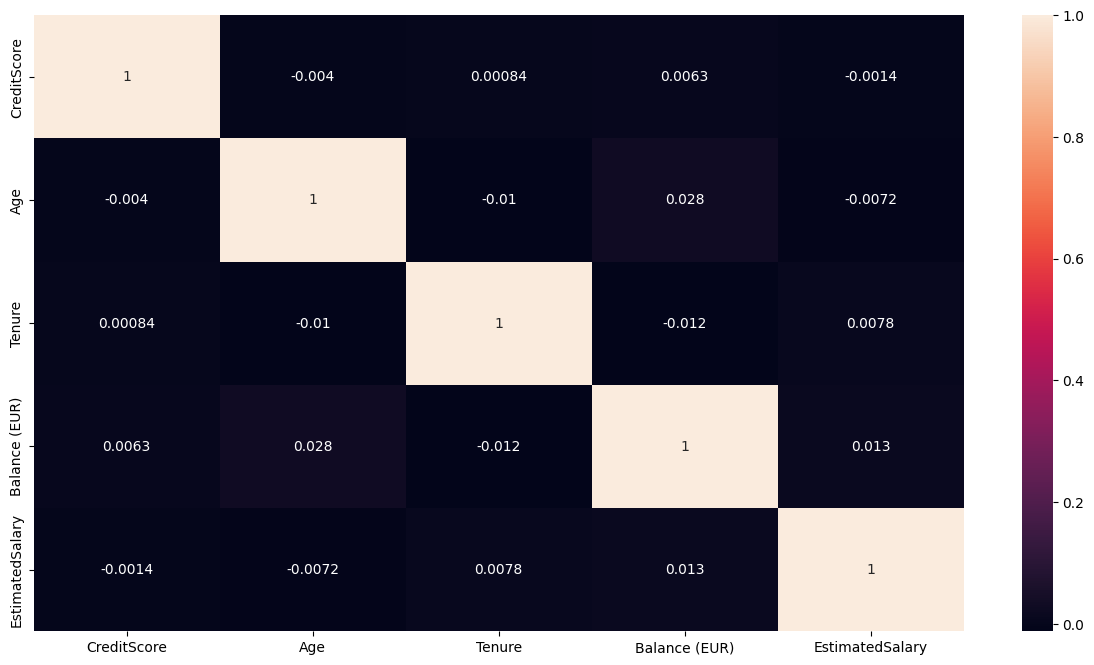

In [15]:
plt.figure(figsize=(15,8))
sn.heatmap(corr_matrix, annot=True)
plt.show()

It's seems that there are few 1 order correlations between variables in the dataset  

In [26]:
from scipy import stats

print(stats.pointbiserialr(df["Exited"], df["EstimatedSalary"]))
print(stats.pointbiserialr(df["Exited"], df["Age"]))
print(stats.pointbiserialr(df["Exited"], df["CreditScore"]))
print(stats.pointbiserialr(df["Exited"], df["Balance (EUR)"]))
print(stats.pointbiserialr(df["Exited"], df["Tenure"]))

SignificanceResult(statistic=0.012096861026844662, pvalue=0.22644042802223605)
SignificanceResult(statistic=0.2853230378350682, pvalue=1.2399313093423167e-186)
SignificanceResult(statistic=-0.027093539754657794, pvalue=0.006738213892192006)
SignificanceResult(statistic=0.118532768771634, pvalue=1.2755633191519232e-32)
SignificanceResult(statistic=-0.014000612253444608, pvalue=0.16152684949473067)


Only age and the target seems to be corellated (around 0.3 with pvalue << 0.5)


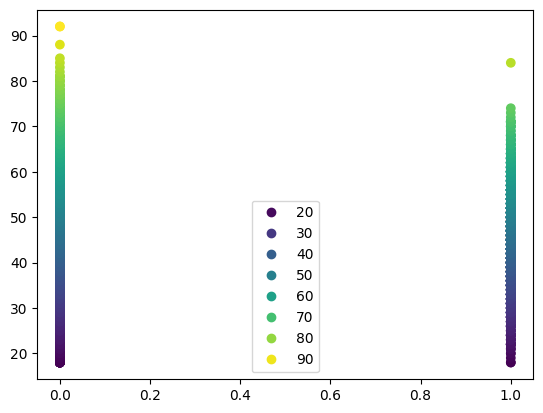

In [31]:
import numpy as np
scatter = plt.scatter(df["Exited"],df["Age"],c=df["Age"].values)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.arange(20,100,10)))